# HuggingFace로 영화리뷰 감정 분석 모델 구현하기

이번 실습에서는 HuggingFace로 영화리뷰 감정 분석과 같은 text 분류 문제를 위한 모델을 구현합니다.
먼저 필요한 library들을 설치하고 import합니다.

In [1]:
!pip install transformers datasets evaluate accelerate scikit-learn

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00


In [2]:
import random
import evaluate
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

## Dataset 준비

그 다음 감정 분석을 위해 사용할 imdb dataset을 `load_dataset` 함수로 다운로드 받습니다.

In [ ]:
imdb = load_dataset("imdb")
imdb

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

`load_dataset`은 HuggingFace의 `datasets` library의 함수로, HuggingFace의 hub에서 dataset을 다운로드 받을 수 있도록 만든 함수입니다.
출력 결과를 보시면 `imdb`는 `train`, `test`, 그리고 `unsupervised` data로 구성되어있습니다.
이 중에서 우리는 `train`과 `test`를 활용합니다.

`train` data를 한 번 살펴보겠습니다.

In [ ]:
imdb['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

`train`과 `test`의 각 data는 `text`와 `label`로 구성되어있습니다.
각각은 영화리뷰와 해당 영화리뷰의 긍정/부정 여부를 의미합니다.
이는 이전 주차들에서 사용한 imdb dataset과 동일합니다.

이번에는 tokenizer를 불러와서 미리 text들을 tokenize합니다.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)

imdb_tokenized = imdb.map(preprocess_function, batched=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenizer를 실행할 때 넘겨주었던 `truncation` 옵션은 주어진 text가 일정 길이 이상이면 잘라내라는 의미입니다.
만약 특정 길이 값이 같이 주어지지 않는다면 `bert-base-cased`를 학습할 때 사용한 text의 최대 길이를 기준으로 값을 결정합니다.

In [ ]:
imdb_tokenized['train'][0].keys()

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

마지막 출력 결과를 보면, `text`와 `label` 이외에 `input_ids`가 생기신 것을 확인하실 수 있습니다.
이는 우리가 `AutoTokenizer.from_pretrained`로 불러온 tokenizer로 text를 token들로 나누고 정수 index로 변환한 결과입니다.

이번에는 `train` data를 쪼개 training data와 validation data를 만들어보겠습니다.

In [ ]:
imdb_split = imdb_tokenized['train'].train_test_split(test_size=0.2)
imdb_train, imdb_val = imdb_split['train'], imdb_split['test']
imdb_test = imdb_tokenized['test']

HuggingFace `datasets`로 불러온 dataset은 `train_test_split`으로 쉽게 쪼갤 수 있습니다.

다음은 각 split의 크기입니다.

In [ ]:
len(imdb_train), len(imdb_val), len(imdb_test)

(20000, 5000, 25000)

## Model 구현

이번에는 text 분류를 수행할 Transformer를 구현합니다.
이전에는 Transformer의 구성 요소들을 직접 구현하여 합쳤습니다.
이번에는 HuggingFace의 BERT를 활용하여 인자만 넘겨주는 식으로 구현해보겠습니다:

In [ ]:
from transformers import BertConfig

config = BertConfig()

config.hidden_size = 64  # BERT layer의 기본 hidden dimension
config.intermediate_size = 64  # FFN layer의 중간 hidden dimension
config.num_hidden_layers = 2  # BERT layer의 개수
config.num_attention_heads = 4  # Multi-head attention에서 사용하는 head 개수
config.num_labels = 2  # 마지막에 예측해야 하는 분류 문제의 class 개수

model = AutoModelForSequenceClassification.from_config(config)

BERT는 이전에 배운 Transformer의 architecture를 그대로 사용합니다.
그래서 BERT의 옵션들만 수정하면 vanilla Transformer를 쉽게 구현할 수 있습니다.

Transformer 구현 이외에 분류 문제에 맞춰 첫 번째 token을 linear classifier를 거치는 등의 과정은 `AutoModelForSequenceClassification`이 구현해줍니다.
즉, 우리가 `config`로 넘겨주는 BERT의 마지막에 linear classifier를 달아주는 역할을 합니다.

## 학습 코드

다음은 위에서 구현한 Transformer를 imdb로 학습하는 코드를 구현합니다.
먼저 다음과 같이 학습 인자들을 정의합니다.

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='hf_transformer',  # 모델, log 등을 저장할 directory
    num_train_epochs=10,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    per_device_eval_batch_size=128,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-3,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
)

각각의 부분들은 이전 주차에서 배웠던 내용들을 설정하는 것에 불과하다는 것을 알 수 있습니다.
요약하면 다음과 같습니다:
- `epochs`: training data를 몇 번 반복할 것인지 결정합니다.
- `batch_size`: training data를 얼마나 잘게 잘라서 학습할 것인지 결정합니다.
- `learning_rate`: optimizer의 learning rate를 얼마로 할 것인지 결정합니다.
위의 부분들 이외에도 사소한 구현 요소들도 지정할 수 있습니다.

다음은 loss 이외의 평가 함수들을 구현하는 방법입니다.

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

`evaluate` 또한 HuggingFace의 library로 다양한 평가 함수들을 제공하고 있습니다.
이번 실습의 경우, 감정 분석 문제는 분류 문제이기 때문에 정확도를 계산할 수 있습니다.
위와 같이 예측 결과(`pred`)와 실제 label(`labels`)가 주어졌을 때 정확도를 계산하는 것은 `evaluate`의 accuracy 함수로 구현할 수 있습니다.

마지막으로 위의 요소들을 종합하여 학습할 수 있는 `Trainer`를 구현합니다.

In [ ]:
from transformers import EarlyStoppingCallback


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=imdb_train,
    eval_dataset=imdb_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=1)]
)

모델, training 인자, training과 validation data, 부가적인 평가 함수, 그리고 tokenizer를 넘겨주면 끝입니다.
별개로 early stopping과 같은 기능도 주석 친 부분과 같이 `callbacks`로 구현할 수 있으니 참고해주시길 바랍니다.

위와 같이 만든 `Trainer`는 다음과 같이 학습을 할 수 있습니다.

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.455000,0.314496,0.870800
2,0.205400,0.324092,0.878200
3,0.120700,0.397531,0.870200
4,0.059600,0.438264,0.879200
5,0.034100,0.567311,0.864600
6,0.023700,0.580624,0.878400
7,0.014100,0.668507,0.872800
8,0.012000,0.701411,0.871000
9,0.010800,0.700823,0.873600
10,0.009400,0.700814,0.872800


TrainOutput(global_step=1570, training_loss=0.09447823785672523, metrics={'train_runtime': 348.0315, 'train_samples_per_second': 574.661, 'train_steps_per_second': 4.511, 'total_flos': 33699840000000.0, 'train_loss': 0.09447823785672523, 'epoch': 10.0})

보시다시피 training loss는 잘 떨어지는 반면, validation loss는 중간부터 쭉 올라가는 것을 볼 수 있습니다.
Overfitting이 일어났다고 볼 수 있습니다.

위와 같이 학습이 끝난 후 validation loss가 가장 낮은 모델을 가지고 test data의 성능을 평가하는 것은 다음과 같이 구현할 수 있습니다.

In [ ]:
trainer.evaluate(imdb_test)

{'eval_loss': 0.3246372938156128,
 'eval_accuracy': 0.86464,
 'eval_runtime': 25.3668,
 'eval_samples_per_second': 985.54,
 'eval_steps_per_second': 7.727,
 'epoch': 10.0}

이전에 학습 인자에서 `load_best_model_at_end=True`를 넘겨줬기 때문에 `trainer`는 학습이 끝난 후, 기본적으로 validation loss가 가장 좋은 모델을 가지고 `evaluate`를 진행합니다.
실제로 결과를 보면 `eval_loss`가 가장 낮은 validation loss와 유사한 것을 볼 수 있습니다.

평가할 때 사용한 모델은 다음과 같이 저장할 수 있습니다.

In [ ]:
trainer.save_model()

그리고 저장한 모델을 가지고 다른 예시들을 예측하는 것은 다음과 같이 구현할 수 있습니다.

In [ ]:
from transformers import pipeline


classifier = pipeline("sentiment-analysis", model="./hf_transformer/", device='cuda')
print(classifier("The movie was so disgusting..."))
print(classifier("The movie was so amazing!!"))

[{'label': 'LABEL_0', 'score': 0.9797601103782654}]

HuggingFace의 `pipeline`은 다양한 모델들에 대하여 서비스에 사용할 수 있는 형태들을 제공합니다.
여기서는 영화 리뷰가 주어졌을 때, label이 0(부정적인 리뷰)인지 1(긍정적인 리뷰)인지 예측 결과를 보여줄 뿐만 아니라 그 신뢰도를 `score`로 넘겨주게 됩니다.

이처럼 HuggingFace를 활용하면 모델이나 예측, 학습 코드를 구현할 필요 없이 인자로 설정값들만 넘겨주면 쉽게 구현 할 수 있습니다.

## Transfer learning

이번에는 task는 영화 리뷰 감정 분석으로 유지하되, 모델을 distilbert를 fine-tuning하는 것으로 바꿔보겠습니다.
모델은 다음과 같이 불러올 수 있습니다.

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`id2label`과 `label2id`는 예측 결과의 가독성을 위해서 추가하였습니다.
기존과 같이 `AutoModelForSequenceClassification`를 사용하고 있습니다.
달라진 점은 `from_config`가 아닌 `from_pretrained`를 사용한다는 것입니다.
`from_pretrained`를 사용하면 HuggingFace hub에 있는 pre-trained 모델들을 사용할 수 있습니다.
감정 분석 문제의 class 수에 맞춰 `num_labels`를 2로 설정하면 모델 구현은 거의 끝났습니다.

이번에는 마지막 layer를 제외한 parameter들을 freeze해보겠습니다.
그 전에 freeze 해야 하는 layer들을 확인하기 위해 `model`을 출력해보겠습니다.

In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

보시다시피 `distilbert`는 기존의 distilbert 모델에 해당하고 나머지 `pre_classifier`, `classifier`는 text 분류를 위해 새롭게 추가된 layer들입니다.
즉, 다음과 같이 `distilbert`에 해당하는 parameter들만 freeze하면 됩니다.

In [ ]:
for param in model.distilbert.parameters():
  param.requires_grad = False

이러면 모델 구현은 완전히 마쳤습니다.
다음은 distilbert를 pre-train할 때 사용했던 tokenizer를 불러오고, 이 tokenizer를 가지고 이전과 똑같이 imdb dataset를 전처리합니다.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)

imdb_tokenized = imdb.map(preprocess_function, batched=True)
imdb_split = imdb_tokenized['train'].train_test_split(test_size=0.2)
imdb_train, imdb_val = imdb_split['train'], imdb_split['test']
imdb_test = imdb_tokenized['test']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

나머지는 기존의 학습과정과 완전히 동일합니다. `training_args`는 기존과 똑같이 활용할 때 distilbert를 fine-tuning하는 코드는 다음과 같습니다.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=imdb_train,
    eval_dataset=imdb_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()
trainer.save_model()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.402800,0.416730,0.815000
2,0.358200,0.336039,0.860400
3,0.342900,0.372907,0.830800
4,0.342100,0.343459,0.841400
5,0.338800,0.377508,0.834400
6,0.335800,0.315672,0.862200


KeyboardInterrupt: 

학습한 모델에 대한 결과는 다음과 같습니다.

In [ ]:
trainer.predict(imdb_test)

In [ ]:
classifier = pipeline("sentiment-analysis", model="./hf_distilbert/", device='cuda')
print(classifier("The movie was so disgusting..."))
print(classifier("The movie was so amazing!!"))

# 기본과제

## 목표

---

이번 과제에서는 이전 주차 과제에서 활용했던 `fancyzhx/ag_news` 문제를 HuggingFace로 구현하시면 됩니다. 다음 요구사항만 지키시면 됩니다.

-  `test` split은 학습에 활용되면 안됩니다.
-  `trainer.train()`에 대한 log가 남아있어야 합니다.
-  최종 모델의 `test` split에 대한 정확도가 print되어야 하며, 90%를 넘기셔야 합니다.
-  다음 예시에 대한 예측 결과를 출력하셔야 합니다.
    
    ```
    UK charges 8 in terror plot linked to alert in US LONDON, AUGUST 17: Britain charged eight terror suspects on Tuesday with conspiracy to commit murder and said one had plans that could be used in striking US buildings that were the focus of security scares this month.
    ```
    

이외에는 validation data 유무, 모델 architecture, hyper-parameter 등은 위의 조건만 만족한다는 가정 하에서 마음대로 수정하셔도 됩니다.

## Dataset 준비

In [7]:
ag_news_dataset = load_dataset("fancyzhx/ag_news")
ag_news_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [8]:
ag_news_dataset['train'][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [9]:
# class 준비
ag_news_classes = ag_news_dataset['train'].features['label'].names
num_classes = len(ag_news_classes)
ag_news_classes, num_classes

(['World', 'Sports', 'Business', 'Sci/Tech'], 4)

In [10]:
# 가독성 위한 label 준비
id2label = {i: category for i, category in enumerate(ag_news_classes)}
label2id = {category: i for i, category in enumerate(ag_news_classes)}
print(id2label)
print(label2id)

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
{'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}


In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)

ag_news_tokenized = ag_news_dataset.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [8]:
ag_news_tokenized['train'][0].keys()

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

In [9]:
# 20%는 validation으로 사용
ag_news_split = ag_news_tokenized['train'].train_test_split(test_size=0.2)
ag_news_train, ag_news_val = ag_news_split['train'], ag_news_split['test']
ag_news_test = ag_news_tokenized['test']

In [10]:
len(ag_news_train), len(ag_news_val), len(ag_news_test)

(96000, 24000, 7600)

sample classificaion 위한 코드

In [19]:
def sample_classification(classifier, sample_amount=10):
  correct_cnt = 0
  wrong_cnt = 0

  for i in range(sample_amount):
    label = id2label[ag_news_test[i]['label']]
    text = ag_news_test[i]['text']

    cls_result = classifier(text)[0]['label']

    print(f"Text: {text}")
    print(f"Label: {label}")
    print(f"Predicted: {cls_result}\n")

    if label == cls_result:
      correct_cnt += 1
    else:
      wrong_cnt += 1

  return correct_cnt, wrong_cnt

## Plot 준비

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracies(accuracy1, accuracy2, label1='accuracy1', label2='accuracy2'):
  x1 = np.arange(len(accuracy1))
  x2 = np.arange(len(accuracy2))

  plt.plot(x1, accuracy1, label=label1)
  plt.plot(x2, accuracy2, label=label2)
  plt.legend()
  plt.show()

In [18]:
from transformers import TrainerCallback

# Callback 클래스 정의 (accuracy_list를 인자로 받음)
class AccuracyCallback(TrainerCallback):
    def __init__(self, accuracy_list):
        # accuracy_list를 받아서 내부적으로 저장
        self.accuracy_list = accuracy_list

    def on_evaluate(self, args, state, control, **kwargs):
        # Trainer의 metrics 정보에서 accuracy 추출 후 전달된 리스트에 저장
        accuracy = kwargs['metrics'].get('eval_accuracy')
        if accuracy is not None:
            self.accuracy_list.append(accuracy)

## 모델 1. Vanila Transformer

### 코드


In [14]:
from transformers import BertConfig

config = BertConfig()

config.hidden_size = 64  # BERT layer의 기본 hidden dimension
config.intermediate_size = 64  # FFN layer의 중간 hidden dimension
config.num_hidden_layers = 2  # BERT layer의 개수
config.num_attention_heads = 4  # Multi-head attention에서 사용하는 head 개수
config.num_labels = num_classes  # 마지막에 예측해야 하는 분류 문제의 class 개수
config.id2label = id2label
config.label2id = label2id

model = AutoModelForSequenceClassification.from_config(config)

In [15]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='hf_transformer',  # 모델, log 등을 저장할 directory
    num_train_epochs=10,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    per_device_eval_batch_size=128,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-3,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
)

In [16]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [19]:
from transformers import EarlyStoppingCallback

vanila_transformer_accuracy_list = []

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ag_news_train,
    eval_dataset=ag_news_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [
        EarlyStoppingCallback(early_stopping_patience=2),
        AccuracyCallback(vanila_transformer_accuracy_list)
    ]
)

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.425000,0.294837,0.907625
2,0.219100,0.276272,0.912042
3,0.155700,0.307943,0.907167
4,0.112500,0.349286,0.909583


TrainOutput(global_step=3000, training_loss=0.22808623504638673, metrics={'train_runtime': 185.3058, 'train_samples_per_second': 5180.625, 'train_steps_per_second': 40.474, 'total_flos': 22540526223360.0, 'train_loss': 0.22808623504638673, 'epoch': 4.0})

In [26]:
vanila_transformer_accuracy_list

In [23]:
trainer.evaluate(ag_news_test)

{'eval_loss': 0.2752774655818939,
 'eval_accuracy': 0.9131578947368421,
 'eval_runtime': 2.3049,
 'eval_samples_per_second': 3297.291,
 'eval_steps_per_second': 26.031,
 'epoch': 4.0}

In [24]:
trainer.save_model()

In [25]:
from transformers import pipeline

classifier = pipeline("text-classification", model="./hf_transformer/", device='cuda')
print(classifier("UK charges 8 in terror plot linked to alert in US LONDON, AUGUST 17: Britain charged eight terror suspects on Tuesday with conspiracy to commit murder and said one had plans that could be used in striking US buildings that were the focus of security scares this month."))

[{'label': 'World', 'score': 0.9956764578819275}]


### Sample classification

In [26]:
correct_cnt, wrong_cnt = sample_classification(classifier)

print("--------------------------------")
print(f"Correct: {correct_cnt}")
print(f"Wrong: {wrong_cnt}")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Label: Business
Predicted: World

Text: The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
Label: Sci/Tech
Predicted: Sci/Tech

Text: Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.
Label: Sci/Tech
Predicted: Sci/Tech

Text: Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of c

### 결과

- 4 epoch에서 조기종료
- 학습시간: T4 기준 약 3분(4 epoch)
- 정확도: 91.32%
- sample classification: 8/10

## 모델 2. BERT-base (Transfer learning)

### 코드


In [11]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=num_classes, id2label=id2label, label2id=label2id
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
for param in model.distilbert.parameters():
  param.requires_grad = False

참고
- 전체 파라미터 67M 중 0.6M만 업데이트

In [13]:
# requires_grad=True인 파라미터 수를 세는 코드
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params}")
print(f"Total parameters: {total_params}")

Trainable parameters: 593668
Total parameters: 66956548


In [14]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)

ag_news_tokenized = ag_news_dataset.map(preprocess_function, batched=True)
# 20%는 validation으로 사용
ag_news_split = ag_news_tokenized['train'].train_test_split(test_size=0.2)
ag_news_train, ag_news_val = ag_news_split['train'], ag_news_split['test']
ag_news_test = ag_news_tokenized['test']

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [15]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [16]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='hf_transformer',  # 모델, log 등을 저장할 directory
    num_train_epochs=10,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    per_device_eval_batch_size=128,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-3,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
)

In [20]:
bert_accuracy_list = []

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ag_news_train,
    eval_dataset=ag_news_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [AccuracyCallback(bert_accuracy_list)]
)

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.313300,0.269485,0.901208
2,0.271200,0.254846,0.907875
3,0.259200,0.251820,0.908167
4,0.248500,0.238785,0.914167
5,0.239600,0.233254,0.916375
6,0.233100,0.232743,0.917750
7,0.226100,0.225861,0.918542
8,0.219800,0.223452,0.920667
9,0.214200,0.222398,0.920500
10,0.209100,0.220256,0.921417


TrainOutput(global_step=7500, training_loss=0.24342306722005208, metrics={'train_runtime': 1329.9969, 'train_samples_per_second': 721.806, 'train_steps_per_second': 5.639, 'total_flos': 3.939535488705331e+16, 'train_loss': 0.24342306722005208, 'epoch': 10.0})

In [22]:
trainer.evaluate(ag_news_test)

{'eval_loss': 0.22601227462291718,
 'eval_accuracy': 0.9206578947368421,
 'eval_runtime': 7.5362,
 'eval_samples_per_second': 1008.463,
 'eval_steps_per_second': 7.962,
 'epoch': 10.0}

In [23]:
trainer.save_model()

In [24]:
from transformers import pipeline

classifier = pipeline("text-classification", model="./hf_transformer/", device='cuda')
print(classifier("UK charges 8 in terror plot linked to alert in US LONDON, AUGUST 17: Britain charged eight terror suspects on Tuesday with conspiracy to commit murder and said one had plans that could be used in striking US buildings that were the focus of security scares this month."))

[{'label': 'World', 'score': 0.9865424633026123}]


### Sample classification

In [25]:
correct_cnt, wrong_cnt = sample_classification(classifier)

print("--------------------------------")
print(f"Correct: {correct_cnt}")
print(f"Wrong: {wrong_cnt}")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Label: Business
Predicted: Business

Text: The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
Label: Sci/Tech
Predicted: Sci/Tech

Text: Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.
Label: Sci/Tech
Predicted: Sci/Tech

Text: Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur o

### 결과

- 학습시간: A100 기준 약 22분(10 epoch)
- 정확도: 92.07%
- sample classification: 10/10

## 정리

- BERT를 Transfer learning하는 것이 미세하게 성능이 더 잘나옴.
  -  Vanilla Transformer: 91.32%
  -  BERT: 92.07%
- 학습시간은 상당히 큰 차이가 남.
- 1 epoch 당 학습시간
  - Vanila Transformer: 약 1분 (T4 기준)
  - BERT: 약 2분 20초 (A100 기준)
  - GPU 성능을 감안하면 훨씬 큰 차이
- 실제로 업데이트 되는 파라미터는 BERT를 Transfer learning하는 것이 약 3배 적음 (0.6M vs 2M)
- 추론에 쓰이는 파라미터가 훨씬 많은 것이 원인이 아닐지? (67M vs 2M)

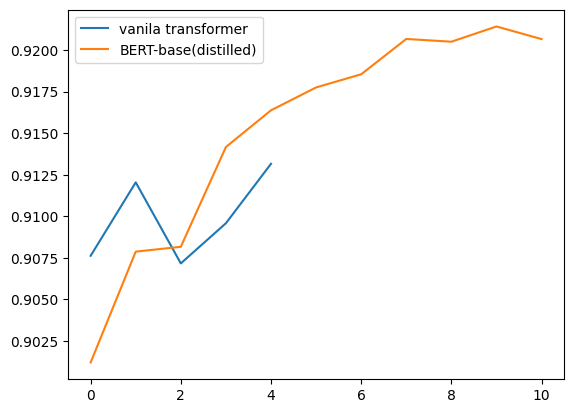

In [32]:
plot_accuracies(vanila_transformer_accuracy_list, bert_accuracy_list, 'vanila transformer', 'BERT-base(distilled)')

## 목표

---

이번 과제는 자연어 task 중 하나인 MNLI를 해결하는 모델을 HuggingFace로 학습하는 것입니다. MNLI를 요약하면 다음과 같습니다.

- **입력**: premise에 해당하는 문장과 hypothesis에 해당하는 문장 두 개가 입력으로 들어옵니다.
- **출력:** 분류 문제로, 두 문장이 들어왔을 때 다음 세 가지를 예측하시면 됩니다.
    - **Entailment:** 두 문장에 논리적 모순이 없습니다.
    - **Neutral:** 두 문장은 논리적으로 관련이 없습니다.
    - **Contradiction:** 두 문장 사이에 논리적 모순이 존재합니다.

이 때, 다음 요구사항이 담긴 colab notebook을 만들어내시면 됩니다:

- `load_dataset("nyu-mll/glue", "mnli")` 로 dataset을 불러옵니다.
    - 학습 때는 `train` split만 활용하셔야 합니다. 나머지 split은 사용불가입니다.
    - Validation data가 필요한 경우, `train` split에서 가져오셔야 합니다.
-  `trainer.train()`를 통해 학습된 log가 남아있어야 합니다.
-  Dataset의 `validation_matched`에 대한 성능을 출력하고, 50%를 넘기셔야 합니다.

이전 과제와 똑같이 validation data 유무, 모델 architecture, hyper-parameter 등은 위의 조건만 만족한다는 가정 하에서 마음대로 수정하셔도 됩니다.

## Dataset 준비

In [ ]:
from datasets import load_dataset

glue_dataset = load_dataset("nyu-mll/glue", "mnli")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [ ]:
glue_dataset['train'][0]

{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
 'hypothesis': 'Product and geography are what make cream skimming work. ',
 'label': 1,
 'idx': 0}

In [ ]:
# class 준비
glue_classes = glue_dataset['train'].features['label'].names
num_classes = len(glue_classes)
glue_classes, num_classes

(['entailment', 'neutral', 'contradiction'], 3)

In [ ]:
# 가독성 위한 label 준비
id2label = {i: category for i, category in enumerate(glue_classes)}
label2id = {category: i for i, category in enumerate(glue_classes)}
print(id2label)
print(label2id)

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}
{'entailment': 0, 'neutral': 1, 'contradiction': 2}


In [ ]:
from transformers import AutoTokenizer

# BERT 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### 가장 긴 Sequence 확인

- BERT는 최대 512개의 토큰을 처리할 수 있음.
- 데이터 셋의 시퀀스 길이가 적당한지 확인해야 함.
- premise(전제) sequence의 길이가 512 이상이라면, truncation 필요
- 확인 결과: 426(전제) + 79(가설) + 3(특수 토큰) = 508
- 512보다 작으므로 truncation 없이 sequence를 만들어도 됨

In [ ]:
# 전제(premise)와 가설(hypothesis) 시퀀스의 최대 길이와 실제 가장 긴 문장을 확인하는 함수
def get_max_lengths_and_examples(dataset):
    max_premise_length = 0
    max_hypothesis_length = 0
    longest_premise = ""
    longest_hypothesis = ""

    for example in dataset['train']:  # 'train' 데이터셋에서만 확인
        premise = example['premise']
        hypothesis = example['hypothesis']

        # 전제와 가설 토크나이징
        tokenized_premise = tokenizer(premise, add_special_tokens=False)['input_ids']
        tokenized_hypothesis = tokenizer(hypothesis, add_special_tokens=False)['input_ids']

        # 가장 긴 전제 찾기
        if len(tokenized_premise) > max_premise_length:
            max_premise_length = len(tokenized_premise)
            longest_premise = premise

        # 가장 긴 가설 찾기
        if len(tokenized_hypothesis) > max_hypothesis_length:
            max_hypothesis_length = len(tokenized_hypothesis)
            longest_hypothesis = hypothesis

    return (max_premise_length, longest_premise), (max_hypothesis_length, longest_hypothesis)

# 전제 시퀀스와 가설 시퀀스의 최대 길이와 가장 긴 문장 확인
max_premise_info, max_hypothesis_info = get_max_lengths_and_examples(glue_dataset)

print(f"Premise 시퀀스의 최대 길이: {max_premise_info[0]}")
print(f"가장 긴 premise 문장: {max_premise_info[1]}")

print(f"Hypothesis 시퀀스의 최대 길이: {max_hypothesis_info[0]}")
print(f"가장 긴 hypothesis 문장: {max_hypothesis_info[1]}")

Premise 시퀀스의 최대 길이: 426
가장 긴 premise 문장: well uh that's kind of obvious i mean they're even carrying it to to where now uh that they advertise on TV you know if your if you uh you know have done this or if you need this uh uh we'll sue for you and you don't have to pay us unless you but then what they don't tell you is that if you if they win you give them at least a third of the of the thing that they win so  i don't know it is uh it's getting to be more business now rather than uh actually uh dealing with the crime than with uh um the uh punishment they the the lawyers are just in it for the money  i'm i'm convinced i know i i agree with you i think you're real you're very right that the politicians should i think they should have an equal amount of you know maybe they can have a few but i think most of them should be not uh lawyers in the fact and that's way way they've gotten into politics it's because of the the law things you know the loops and everything but uh but no i know we 

### 토크나이징

In [ ]:
def preprocess_function(data):
  return tokenizer(data["premise"], data["hypothesis"], truncation=True)

glue_tokenized = glue_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [ ]:
glue_tokenized

glue_split = glue_tokenized['train'].train_test_split(test_size=0.2)
glue_train, glue_val = glue_split['train'], glue_split['test']
glue_test = glue_tokenized['validation_matched']

sample classificaion 위한 코드

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline


"""
# 커스텀 파이프라인 정의

사용 예시
# 훈련된 모델 경로로 커스텀 파이프라인 생성
custom_classifier = CustomNLIPipeline(model_path="./hf_transformer/", device='cuda')

# 전제와 가설을 입력으로 예측
premise = "The cat sat on the mat."
hypothesis = "The cat is sitting."
predicted_class = custom_classifier(premise, hypothesis)

print(f"예측된 클래스: {predicted_class}")
"""
class CustomNLIPipeline:
    def __init__(self, model_path, id2label, label2id, device='cpu'):
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.device = device

        if id2label is not None:
          self.model.config.id2label = id2label
        if label2id is not None:
          self.model.config.label2id = label2id

    def __call__(self, premise, hypothesis):
        # 문장 쌍을 함께 토큰화
        inputs = self.tokenizer(premise, hypothesis, return_tensors="pt", truncation=True).to(self.device)
        if "token_type_ids" in inputs:
            del inputs["token_type_ids"]

        # 모델 예측
        outputs = self.model(**inputs)
        # 로짓 값에서 예측된 클래스를 가져옴
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
        if self.model.config.id2label is not None:
          predicted_class = self.model.config.id2label[predicted_class]


        return predicted_class

In [ ]:
def sample_classification(classifier, sample_amount=10):
  correct_cnt = 0
  wrong_cnt = 0

  for i in range(sample_amount):
    label = id2label[glue_test[i]['label']]
    premise = glue_test[i]['premise']
    hypothesis = glue_test[i]['hypothesis']
    cls_result = classifier(premise, hypothesis)

    print(f"Premise: {premise}")
    print(f"Hypothesis: {hypothesis}")
    print(f"Label: {label}")
    print(f"Predicted: {cls_result}\n")

    if label == cls_result:
      correct_cnt += 1
    else:
      wrong_cnt += 1

  return correct_cnt, wrong_cnt

## 모델 1. Vanilla Transformer

#### 코드

In [ ]:
from transformers import BertConfig, AutoModelForSequenceClassification

config = BertConfig()

config.hidden_size = 64  # BERT layer의 기본 hidden dimension
config.intermediate_size = 64  # FFN layer의 중간 hidden dimension
config.num_hidden_layers = 2  # BERT layer의 개수
config.num_attention_heads = 4  # Multi-head attention에서 사용하는 head 개수
config.num_labels = num_classes  # 마지막에 예측해야 하는 분류 문제의 class 개수
config.id2label = id2label
config.label2id = label2id

model = AutoModelForSequenceClassification.from_config(config)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='hf_transformer',
    num_train_epochs=10,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_strategy="epoch",
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,
    load_best_model_at_end=True
)

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import EarlyStoppingCallback

vanila_transformer_accuracy_list = []

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=glue_train,
    eval_dataset=glue_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [
        EarlyStoppingCallback(early_stopping_patience=2),
        AccuracyCallback(vanila_transformer_accuracy_list)
    ]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.964600,0.898411,0.580397
2,0.861400,0.861935,0.608752
3,0.800500,0.845530,0.625304
4,0.750300,0.847234,0.625673
5,0.708400,0.873666,0.624540


TrainOutput(global_step=12275, training_loss=0.8170076513970214, metrics={'train_runtime': 1332.5039, 'train_samples_per_second': 2357.674, 'train_steps_per_second': 18.424, 'total_flos': 213655854746250.0, 'train_loss': 0.8170076513970214, 'epoch': 5.0})

In [ ]:
trainer.evaluate(glue_test)

{'eval_loss': 0.8278183341026306,
 'eval_accuracy': 0.6362710137544575,
 'eval_runtime': 3.7894,
 'eval_samples_per_second': 2590.112,
 'eval_steps_per_second': 20.32,
 'epoch': 5.0}

In [ ]:
trainer.save_model()

In [ ]:
from transformers import pipeline

classifier = CustomNLIPipeline(model_path="./hf_transformer/", device='cuda', label2id=label2id, id2label=id2label)

### Sample classification

In [ ]:
correct_cnt, wrong_cnt = sample_classification(classifier)

print("--------------------------------")
print(f"Correct: {correct_cnt}")
print(f"Wrong: {wrong_cnt}")

Premise: The new rights are nice enough
Hypothesis: Everyone really likes the newest benefits 
Label: neutral
Predicted: contradiction

Premise: This site includes a list of all award winners and a searchable database of Government Executive articles.
Hypothesis: The Government Executive articles housed on the website are not able to be searched.
Label: contradiction
Predicted: contradiction

Premise: uh i don't know i i have mixed emotions about him uh sometimes i like him but at the same times i love to see somebody beat him
Hypothesis: I like him for the most part, but would still enjoy seeing someone beat him.
Label: entailment
Predicted: neutral

Premise: yeah i i think my favorite restaurant is always been the one closest  you know the closest as long as it's it meets the minimum criteria you know of good food
Hypothesis: My favorite restaurants are always at least a hundred miles away from my house. 
Label: contradiction
Predicted: neutral

Premise: i don't know um do you do a l

### 결과

- 5 epoch에서 조기종료
- 학습시간: A100 기준 약 22분(5 epoch)
- 정확도: 63.63%
- sample classification: 5/10

## 모델 2. BERT-base (Transfer learning)

### 코드


In [ ]:
# tokenizer 다름에 주의!
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def preprocess_function(data):
  return tokenizer(data["premise"], data["hypothesis"], truncation=True)

glue_tokenized = glue_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

In [ ]:
# 20%는 validation으로 사용
glue_split = glue_tokenized['train'].train_test_split(test_size=0.2)
glue_train, glue_val = glue_split['train'], glue_split['test']
glue_test = glue_tokenized['validation_matched']

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=num_classes, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for param in model.distilbert.parameters():
  param.requires_grad = False

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='hf_transformer',
    num_train_epochs=5, # 리소스 사용이 너무 많아서 5 epoch으로 줄임
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_strategy="epoch",
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,
    load_best_model_at_end=True
)

In [ ]:
bert_accuracy_list = []

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=glue_train,
    eval_dataset=glue_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [AccuracyCallback(bert_accuracy_list)]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.021500,0.987067,0.511886
2,0.997700,0.970887,0.525356
3,0.987200,0.963927,0.529061
4,0.979200,0.957270,0.533836
5,0.972800,0.954503,0.536777


TrainOutput(global_step=12275, training_loss=0.9916692655295316, metrics={'train_runtime': 1688.9021, 'train_samples_per_second': 930.075, 'train_steps_per_second': 7.268, 'total_flos': 5.050537167057986e+16, 'train_loss': 0.9916692655295316, 'epoch': 5.0})

In [ ]:
trainer.evaluate(glue_test)

{'eval_loss': 0.9521942138671875,
 'eval_accuracy': 0.5392766174223128,
 'eval_runtime': 8.0192,
 'eval_samples_per_second': 1223.943,
 'eval_steps_per_second': 9.602,
 'epoch': 5.0}

In [ ]:
trainer.save_model()

In [ ]:
from transformers import pipeline

classifier = CustomNLIPipeline(model_path="./hf_transformer/", device='cuda', label2id=label2id, id2label=id2label)

### Sample classification

In [ ]:
correct_cnt, wrong_cnt = sample_classification(classifier)

print("--------------------------------")
print(f"Correct: {correct_cnt}")
print(f"Wrong: {wrong_cnt}")

Premise: The new rights are nice enough
Hypothesis: Everyone really likes the newest benefits 
Label: neutral
Predicted: neutral

Premise: This site includes a list of all award winners and a searchable database of Government Executive articles.
Hypothesis: The Government Executive articles housed on the website are not able to be searched.
Label: contradiction
Predicted: contradiction

Premise: uh i don't know i i have mixed emotions about him uh sometimes i like him but at the same times i love to see somebody beat him
Hypothesis: I like him for the most part, but would still enjoy seeing someone beat him.
Label: entailment
Predicted: entailment

Premise: yeah i i think my favorite restaurant is always been the one closest  you know the closest as long as it's it meets the minimum criteria you know of good food
Hypothesis: My favorite restaurants are always at least a hundred miles away from my house. 
Label: contradiction
Predicted: neutral

Premise: i don't know um do you do a lot 

### 결과

- 학습시간: A100 기준 약 28분(5 epoch)
- 정확도: 53.93%
- sample classification: 7/10

## 정리

- 두 모델 각각 5 epoch 학습
- Classification 정확도는 오히려 Vanila Transformer가 높음.
  - Vanilla Transformer: 63.63%
  - BERT: 53.93%
- 1 epoch 당 학습시간 (A100 기준)
  - Vanila Transformer: 약 4분 30초
  - BERT: 약 5분 40초
- 더 적은 파라미터 수로 더 나은 결과. (2M vs 67M)
- 그래프 추이를 봤을 때, BERT 학습의 epoch을 늘이면 정확도가 더 올라갈 수도 있음.

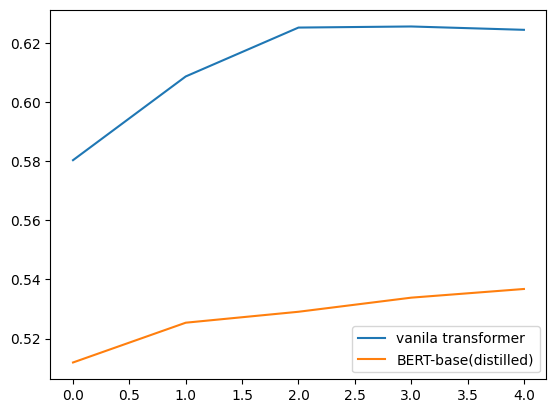

In [36]:
plot_accuracies(vanila_transformer_accuracy_list, bert_accuracy_list, 'vanila transformer', 'BERT-base(distilled)')